# Example: Memory kernel extraction from a LAMMPS simulation of ions in a water box

In this notebook we will load LAMMPS simulation output containing for data for ions in water (SPC/E) and use GLEPy to extract the memory kernel on the ion degrees of freedom. 

In [12]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from ion_potentials import ion_frc_iterator 
import gleqpy.memory.time as memt

ModuleNotFoundError: No module named 'gleqpy'

## Setup and run simulation
The first step is to set up and run the simulation of the water + ion box. The "sim.py" script in this directory does this for you using the "ion_explicit.dat" LAMMPS parameter file. 

## Compute memory kernel from simulation data

Now we read lammps output "run_data.laampstrj" which containts positions, velocities, and forces on all the ions. In order to compute the memory kernel, we need to solve the Volterra equation:

$$ C_f(t) = - \int_0^t K(t-\tau) C_v(\tau) d\tau $$

where 

$$C_f(t) = \left \langle \left[m \ddot{x}(t) + \frac{d W}{dx}(t) \right]  \dot{x}(0) \right \rangle $$

and 

$$C_v(t) = \left \langle \dot{x}(\tau) \dot{x}(0) \right \rangle $$

In order to compute $C_f$ we need a model of the potential of mean force $W(x)$. The PMF is NOT the same as the bare potential energy of the ions, it is an averaged potential energy that includes the entropy of solvent configurations around each ion configuration. A 2-body PMF can be computed in a number ways and varying levels of accuracy. Here, I will use a Debye + LJ potential as a crude approximation to $W(x)$. I note that in general the fidelity of the memory kernel extracted by solving the Volterra equation depends on the fidelity of the potential of mean force. Using a highly innacurate PMF can lead to memory kernels which do not converge. 

In [ ]:
#### Read data from lammpstrj

file = open('explicit_run.lammpstrj','r')

data_all = []

#Extract Number of Atoms
line = file.readline()
line = file.readline()
line = file.readline()
line = file.readline()
natom = int(line)

#Extract Size of Datapoints
line = file.readline()
line = file.readline()
line = file.readline()
line = file.readline()
line = file.readline()
ndata = len(line.split(" ")) - 2

#Extract only relevant data from lammpstr
while len(line) != 0:
    if line[0:11] == "ITEM: ATOMS":
        data_t = np.zeros((natom,ndata-2),dtype=np.float64)
        for i in range(natom):
            data_n = (file.readline()).split(" ")
            data_t[i,:] = data_n[2:]
        data_all.append(data_t)
    line = file.readline()
data_all = np.array(data_all)

In [ ]:
# Seperate data
pos = data_all[:,:,0:3]
vel = data_all[:,:,3:6]
frc = data_all[:,:,6:9]
nt    = np.size(pos,axis=0) #number of timesteps
natom = np.size(pos,axis=1) #number of atoms
tcorr = 300 # number of timesteps for computing time-correlation functions
dt    = 0.005

# Ion Parameters
m = np.hstack((6.941 * np.ones(natom//2), 35.453 * np.ones(natom//2))) #masses
q = np.hstack((np.ones(natom//2),-np.ones(natom//2))) # charges
eps = np.hstack((1.4088967296000001 * np.ones(natom//2),0.05349244 * np.ones(natom//2))) #LJ epsilon
sigma = np.hstack((0.14094017720980168 * np.ones(natom//2),0.48304528497569194 * np.ones(natom//2))) #LJ sigma

# Print Debye Screning Length
c_1 = (natom//2)/(2.5**3)
c_2 = (natom//2)/(2.5**3)
K = np.sqrt( 138.935458 * 4 * np.pi/(70.7 * 2.494) * ((1 * c_1) + (1 * c_2)) )
print("Debye-screening length is ",(1/K).round(3),"nm")

# Extract and Calculate Forces
acc    = frc/m[:,None] # acceleration
frces  = ion_frc_iterator(pos,2.5)
#frc_md_coul = frces.calc_coulomb(q, -1, eps=70.7)
frc_md_dbye = frces.calc_debye(q,K,-1,eps=70.7)
frc_md_lj   = frces.calc_lj(eps, sigma,12.0)
pmf = frc_md_lj + frc_md_dbye

pos = pos.reshape(nt,-1)
vel = vel.reshape(nt,-1)
frc = frc.reshape(nt,-1)
acc = acc.reshape(nt,-1)
pmf = pmf.reshape(nt,-1)

Debye-screening length is  0.296 nm


In [ ]:
# Calculate Ion Time Correlation Functions
m = np.hstack((6.941 * np.ones(natom//2*3), 35.453 * np.ones(natom//2*3))) #masses

print("calculating velocity tcfs")
vel_tcf = memt.calc_tcf(vel,vel, max_t=tcorr)
dvel_tcf = -memt.calc_tcf(vel,acc,max_t=tcorr)

print("calculating force tcf")
frc_tcf   =  memt.calc_tcf(acc - pmf/m, vel, max_t=tcorr)
dfrc_tcf  = -memt.calc_tcf(acc - pmf/m, acc, max_t=tcorr)

# Seperate into Cation and Anion Contributions
c_indx = np.arange(0,natom//2*3,1)
a_indx = np.arange(natom//2*3,natom*3,1)

vel_tcf_c  = np.mean(vel_tcf[:,c_indx],axis=1)
dvel_tcf_c = np.mean(dvel_tcf[:,c_indx],axis=1)
dfrc_tcf_c = np.mean(dfrc_tcf[:,c_indx],axis=1)

vel_tcf_a  = np.mean(vel_tcf[:,a_indx],axis=1)
dvel_tcf_a = np.mean(dvel_tcf[:,a_indx],axis=1)
dfrc_tcf_a = np.mean(dfrc_tcf[:,a_indx],axis=1)

print("calculating memory kernels")
K_dtrapz_c = memt.calc_memory_dtrapz(dvel_tcf_c, dfrc_tcf_c , vel_tcf_c[0], dt)
K_dtrapz_a = memt.calc_memory_dtrapz(dvel_tcf_a, dfrc_tcf_a , vel_tcf_a[0], dt)

calculating velocity tcfs
calculating force tcf
calculating memory kernels


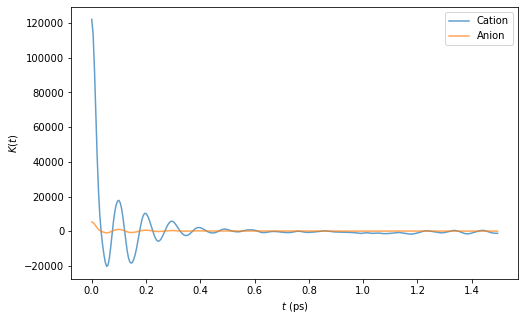

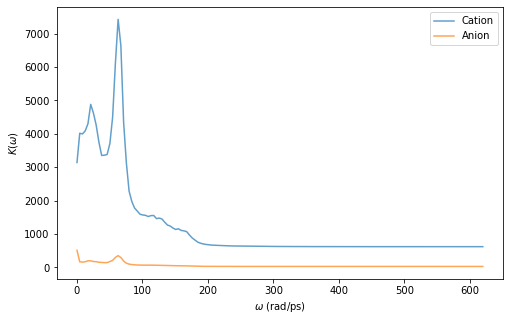

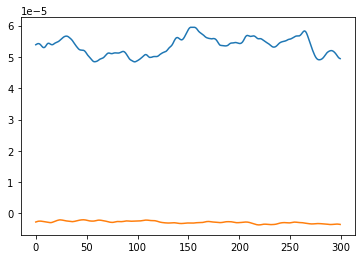

In [ ]:
#####  Plots
t_arr = np.arange(0,tcorr)*dt

# Different Methods of Extracting Memory Kernel
plt.figure(figsize=[8,5])
plt.plot(  t_arr,     K_dtrapz_c, alpha= 0.7, label="Cation")
plt.plot(  t_arr,     K_dtrapz_a, alpha= 0.7, label="Anion")
plt.ylabel(r"$K(t)$")
plt.xlabel("$t$ (ps)")
plt.legend()

# Frequency Space
Kf_c, Kf_a = memt.calc_spectral([K_dtrapz_c,K_dtrapz_a],scale=1/(2*dt))
freq_arr = 2 * np.pi * np.fft.fftfreq(n=tcorr,d=dt)[0:tcorr//2-1]

plt.figure(figsize=[8,5])
plt.plot(freq_arr, Kf_c, label="Cation", alpha=0.7)
plt.plot(freq_arr, Kf_a, label="Anion", alpha=0.7)
plt.ylabel(r"$K(\omega)$")
plt.xlabel(r"$\omega$ (rad/ps)")
plt.legend()

plt.figure()
plt.plot(dvel_tcf[:,c_indx[3]])
plt.plot(dvel_tcf_a)

While the memory kernel does converge (as expected), do not expect the results above to be precise. A more rigorous treatment of the PMF as well as much longer trajectories are needed to give accurate answers. This script is only intended for illustrative purposes. 

## Fit memory kernel to a sum of exponential sinusoids

Here we fit the memory kernel compute in the previous step to a sum of exponentially damped cosines. 

$$K(t) = \sum_j C_j e^{-\gamma_j t} \cos(\omega_j t)$$

We then cast this memory kernel into $A$ matrix form for future simulation in the "ase_gle.ipynb" script

$$K(t) = -\mathbf{A}_{vs} e^{-\mathbf{A}_{s}t} \mathbf{A}_{sv}$$

Coeffs of Terms (ps^-1):  [  941.73 56583.49 49576.31   436.06 14501.21]
Decay Rates (ps^-1):  [ 0.2  17.73  8.31  0.   24.74]
Frequencies (ps^-1):  [  2.79  22.01  62.83  65.97 123.81]


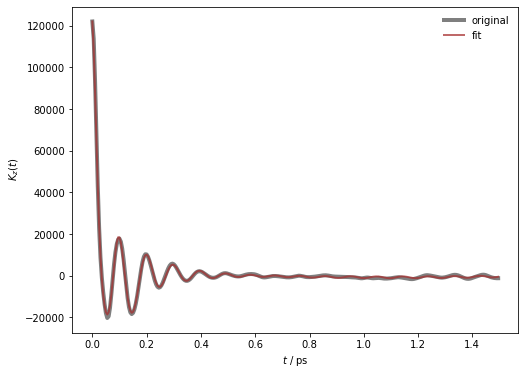

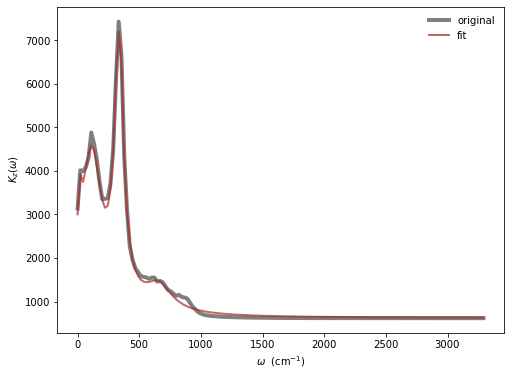

In [ ]:
#### Fit cation memory kernel
Kt_c = K_dtrapz_c

# Set number of terms in fit
nterm = 5

# Frequency conversion factor
radperps_to_cm = 33.356 * 1.0/(2*np.pi)
freq_cm      = freq_arr * radperps_to_cm # Frequency in units of cm-1

# Set Guess for Parameter valyes
coeffs_guess = [10,10,10,10,10]
decays_guess = [1.0,1.0,1.0,1.0,1.0]
freqs_guess = [0,50,80,100,150]

# Fit memory kernel
A = memt.Amatrix()
Ktc_fit, coeffs_fit, decays_fit, freqs_fit = A.fit(t_arr, Kt_c, nterm, coeffs_guess, decays_guess, freqs_guess, bounds=(0.00,np.inf))
Kfc_fit = memt.calc_spectral([Ktc_fit],scale=1/(2*dt))[0]

# Plot Time
plt.figure(figsize=[8,6])
plt.plot(t_arr, Kt_c, linewidth=4, alpha=0.5, color="k")
plt.plot(t_arr, Ktc_fit, linewidth=2, alpha=0.7, color="brown")
plt.xlabel("$t$ / ps")
plt.ylabel(" $K_z(t)$ ")
plt.legend(["original","fit"],frameon=False)

# Plot Frequency
plt.figure(figsize=[8,6])
plt.plot(freq_cm, Kf_c, linewidth=4.0, alpha=0.5, color="k")
plt.plot(freq_cm, Kfc_fit, linewidth=2.0, alpha=0.7, color="brown")
plt.xlabel(r"$\omega$  (cm$^{-1})$")
plt.ylabel(r" $K_z(\omega)$ ")
plt.legend(["original","fit"],frameon=False)

# Print and Output
print("Coeffs of Terms (ps^-1): ",coeffs_fit.round(2))
print("Decay Rates (ps^-1): ",decays_fit.round(2))
print("Frequencies (ps^-1): ",freqs_fit.round(2))

# Write Output
A.params_to_Amat()
A.Amat = A.Amat/1000 #factor of 10^3 converts from 1/ps to 1/fs for LAMMPS
A.write_Amatrix("K_cation.A")

Coeffs of Terms (ps^-1):  [ 165.68 2250.02 1219.85  632.02 1055.09]
Decay Rates (ps^-1):  [ 0.49 17.98  8.13 24.    5.99]
Frequencies (ps^-1):  [  0.    21.24  59.45 122.09  65.17]


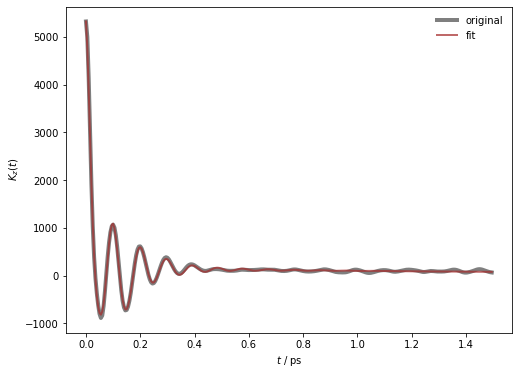

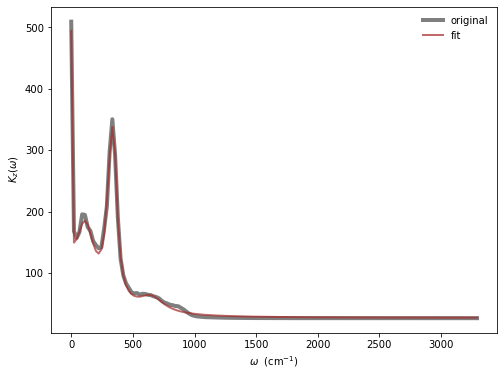

In [ ]:
#### Fit cation memory kernel
Kt_a = K_dtrapz_a

# Set number of terms in fit
nterm = 5

# Frequency conversion factor
radperps_to_cm = 33.356 * 1.0/(2*np.pi)
freq_cm      = freq_arr * radperps_to_cm # Frequency in units of cm-1

# Set Guess for Parameter valyes
coeffs_guess = [10,10,10,10,10]
decays_guess = [1.0,1.0,1.0,1.0,1.0]
freqs_guess = [0,50,80,100,150]

# Fit memory kernel
A = memt.Amatrix()
Kta_fit, coeffs_fit, decays_fit, freqs_fit = A.fit(t_arr, Kt_a, nterm, coeffs_guess, decays_guess, freqs_guess, bounds=(0.00,np.inf))
Kfa_fit = memt.calc_spectral([Kta_fit],scale=1/(2*dt))[0]

# Plot Time
plt.figure(figsize=[8,6])
plt.plot(t_arr, Kt_a, linewidth=4, alpha=0.5, color="k")
plt.plot(t_arr, Kta_fit, linewidth=2, alpha=0.7, color="brown")
plt.xlabel("$t$ / ps")
plt.ylabel(" $K_z(t)$ ")
plt.legend(["original","fit"],frameon=False)

# Plot Frequency
plt.figure(figsize=[8,6])
plt.plot(freq_cm, Kf_a, linewidth=4.0, alpha=0.5, color="k")
plt.plot(freq_cm, Kfa_fit, linewidth=2.0, alpha=0.7, color="brown")
plt.xlabel(r"$\omega$  (cm$^{-1})$")
plt.ylabel(r" $K_z(\omega)$ ")
plt.legend(["original","fit"],frameon=False)

# Print and Output
print("Coeffs of Terms (ps^-1): ",coeffs_fit.round(2))
print("Decay Rates (ps^-1): ",decays_fit.round(2))
print("Frequencies (ps^-1): ",freqs_fit.round(2))

# Write Output
A.params_to_Amat()
A.Amat = A.Amat/1000 #factor of 10^3 converts from 1/ps to 1/fs for LAMMPS
A.write_Amatrix("K_anion.A")